## Imports and Config


In [1]:
# !pip install wget gdown --quiet
!pip install geodatasets --quiet

In [2]:
import os
import json
import random

import pandas as pd
import numpy as np

import torch
import torchvision

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geodatasets

from IPython.display import Audio
from IPython.display import HTML
# from opensoundscape import Audio

In [3]:
use_gpu = torch.cuda.is_available()
device = 'cuda' if use_gpu else 'cpu'
print('Connected device:', device)

Connected device: cpu


In [4]:
# Setup Kaggle API creds
kaggle_creds = {"username":"...","key":"..."}

os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump(kaggle_creds, f)

!chmod 600 ~/.kaggle/kaggle.json

### Download and Extract Data

In [5]:
datasets_csvs = {
    'birdclef-2021': 'https://drive.google.com/uc?id=1q9rPE2brOWGVmNEBXBS9OsTyOiusOEwB'
}

In [6]:
import gdown

data_dir = 'data/'
os.makedirs(data_dir, exist_ok=True)

# downloaded = wget.download(, data_dir)
gdown.download(datasets_csvs['birdclef-2021'], data_dir, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1q9rPE2brOWGVmNEBXBS9OsTyOiusOEwB
To: /content/data/birdclef-datasets-csvs.zip
100%|██████████| 2.90M/2.90M [00:00<00:00, 37.9MB/s]


'data/birdclef-datasets-csvs.zip'

In [7]:
from zipfile import ZipFile

with ZipFile(os.path.join(data_dir, 'birdclef-datasets-csvs.zip'), 'r') as zip_file:
    zip_file.extractall(data_dir)

## Read Data

In [8]:
df_2021 = pd.read_csv(os.path.join(data_dir, 'BirdCLEF-2021/train_metadata.csv'))
df_2024 = pd.read_csv(os.path.join(data_dir, 'BirdCLEF-2024/train_metadata.csv'))

## EDA

Описание на kaggle.  
2021 год.  
https://www.kaggle.com/competitions/birdclef-2021/data  
train_metadata.csv — широкий спектр метаданных предоставляется для данных обучения. Наиболее непосредственно релевантные поля:  
 - primary_label: код для вида птиц. Вы можете просмотреть подробную информацию о кодах птиц, добавив код к https://ebird.org/species/, например, https://ebird.org/species/amecro для американской вороны.  
 - recodist: пользователь, предоставивший запись.  
 - latitude& longitude: координаты места, где была сделана запись. Некоторые виды птиц могут иметь местные «диалекты» криков, поэтому вам может потребоваться поиск географического разнообразия в ваших обучающих данных.  
 - date: хотя некоторые птичьи крики могут воспроизводиться круглый год, например, тревожный крик, некоторые ограничены определенным сезоном. Возможно, вам захочется поискать временное разнообразие в ваших данных для обучения.  
 - filename: имя соответствующего аудиофайла.
  
2024 год.  
https://www.kaggle.com/competitions/birdclef-2024/data  
train_metadata.csv - широкий спектр метаданных. Наиболее непосредственно релевантными полями являются:  
 - primary_label- код для вида птиц. Вы можете просмотреть подробную информацию о кодах птиц, добавив код к https://ebird.org/species/, например, https://ebird.org/species/amecroдля американской вороны. Не все виды имеют собственные страницы; некоторые ссылки не будут работать.  
 - latitude& longitude: координаты места, где была сделана запись. Некоторые виды птиц могут иметь местные «диалекты» криков, поэтому вам может потребоваться поиск географического разнообразия в ваших обучающих данных.  
 - author- Пользователь, предоставивший запись.  
 - filename: имя соответствующего аудиофайла.  

In [9]:
# Смотрим структуру файла:
print('Данные за 2021 год: ')
print(df_2021.info())
display(df_2021.head(2))
print()
print('Данные за 2024 год: ')
print(df_2024.info())
display(df_2024.head(2))

Данные за 2021 год: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62874 entries, 0 to 62873
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     62874 non-null  object 
 1   secondary_labels  62874 non-null  object 
 2   type              62874 non-null  object 
 3   latitude          62874 non-null  float64
 4   longitude         62874 non-null  float64
 5   scientific_name   62874 non-null  object 
 6   common_name       62874 non-null  object 
 7   author            62874 non-null  object 
 8   date              62874 non-null  object 
 9   filename          62874 non-null  object 
 10  license           62874 non-null  object 
 11  rating            62874 non-null  float64
 12  time              62874 non-null  object 
 13  url               62874 non-null  object 
dtypes: float64(3), object(11)
memory usage: 6.7+ MB
None


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url
0,acafly,['amegfi'],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Empidonax virescens,Acadian Flycatcher,Mike Nelson,2012-08-12,XC109605.ogg,Creative Commons Attribution-NonCommercial-Sha...,2.5,09:30,https://www.xeno-canto.org/109605
1,acafly,[],['call'],9.1334,-79.6501,Empidonax virescens,Acadian Flycatcher,Allen T. Chartier,2000-12-26,XC11209.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,?,https://www.xeno-canto.org/11209



Данные за 2024 год: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24459 entries, 0 to 24458
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     24459 non-null  object 
 1   secondary_labels  24459 non-null  object 
 2   type              24459 non-null  object 
 3   latitude          24081 non-null  float64
 4   longitude         24081 non-null  float64
 5   scientific_name   24459 non-null  object 
 6   common_name       24459 non-null  object 
 7   author            24459 non-null  object 
 8   license           24459 non-null  object 
 9   rating            24459 non-null  float64
 10  url               24459 non-null  object 
 11  filename          24459 non-null  object 
dtypes: float64(3), object(9)
memory usage: 2.2+ MB
None


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg


In [10]:
def display_random_samples(df, title):
    samples = df.sample(n=5, random_state=random.randint(0, 1000))

    html_content = f'<h2>{title}</h2><div style="display: flex; gap: 10px;">'
    for _, row in samples.iterrows():
        soundsrc = row['url'] + '/embed?simple=1'
        html_content += f'''
        <div style="background-color: lightblue; width: 360px; height: 135px; display: flex; align-items: center; justify-content: center;">
            <iframe src="{soundsrc}" scrolling="no" frameborder="0" width="340" height="115"></iframe>
        </div>
        '''
    html_content += '</div>'

    display(HTML(html_content))


display_random_samples(df_2021, 'Birdcall samples: Dataset 2021')
display_random_samples(df_2024, 'Birdcall samples: Dataset 2024')

Найдём виды птиц:  
1. Которые есть в обоих датасетах.  
2. Которые есть только в датасете 2021 года.  
3. Которые есть только в датасете 2024 года.  

In [11]:
# уникальные тройки 'primary_label', 'scientific_name' и 'common_name' в датасетах
df_unique_2021 = df_2021[['primary_label', 'scientific_name', 'common_name']].drop_duplicates(ignore_index=True)
df_unique_2024 = df_2024[['primary_label', 'scientific_name', 'common_name']].drop_duplicates(ignore_index=True)
df_unique_2021_2024 = pd.concat([df_unique_2021, df_unique_2024], ignore_index=True)
df_unique_2021_2024 = df_unique_2021_2024.drop_duplicates(ignore_index=True)
# проверяем, что 'primary_label', 'scientific_name' и 'common_name' взаимно однозначно соответствут друг другу (1 к 1)
if df_unique_2021_2024.shape[0] == df_unique_2021_2024.nunique().min():
    print("'primary_label', 'scientific_name' и 'common_name' взаимно однозначно соответствут друг другу (1 к 1)")
else:
    print("'primary_label', 'scientific_name' и 'common_name' НЕ взаимно однозначно соответствут друг другу (1 к 1)")
print()

# так как убедились, что 'primary_label' и 'scientific_name' вазимно однозначно соответствут друг другу (1 к 1):, то дальше будем использовать только 'scientific_name'
df_unique_2021 = df_unique_2021.drop(columns=['scientific_name', 'common_name'])
df_unique_2024 = df_unique_2024.drop(columns=['scientific_name', 'common_name'])

# получим искомые значения видов птиц
# 1. Общие значения
df_2021_2024 = pd.merge(df_unique_2021, df_unique_2024, how='inner', on='primary_label')
# 2. Значения только в датасете 2021 года
df_2021_only = df_unique_2021[~df_unique_2021['primary_label'].isin(df_unique_2024['primary_label'])]
# 3. Значения только в датасете 2024 года
df_2024_only = df_unique_2024[~df_unique_2024['primary_label'].isin(df_unique_2021['primary_label'])]

# посмотрим, что получилось:
print('Число уникальных видов, представленных в обоих датасетах: ', df_2021_2024.shape[0])
print('Число уникальных видов, представленных только в датасете 2021 года: ', df_2021_only.shape[0])
print('Число уникальных видов, представленных только в датасете 2024 года: ', df_2024_only.shape[0])

'primary_label', 'scientific_name' и 'common_name' взаимно однозначно соответствут друг другу (1 к 1)

Число уникальных видов, представленных в обоих датасетах:  7
Число уникальных видов, представленных только в датасете 2021 года:  390
Число уникальных видов, представленных только в датасете 2024 года:  175


### [ Alexey ]

> География наблюдений по базе 2021 года

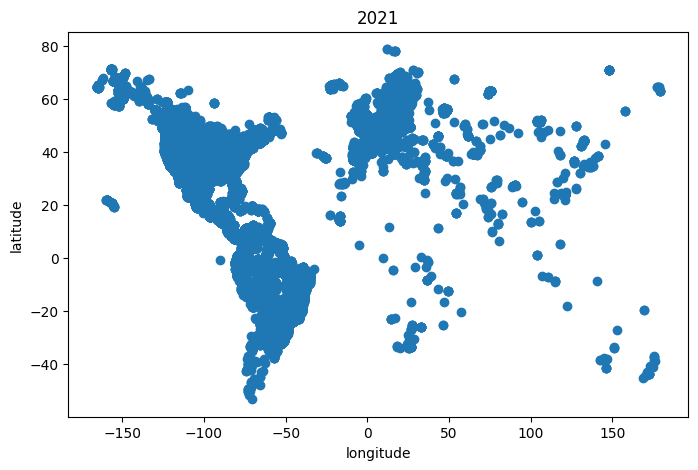

In [12]:
plt.figure(figsize=(8, 5))
plt.scatter(df_2021["longitude"], df_2021["latitude"])
plt.title("2021")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

География наблюдений по базе 2024 года:

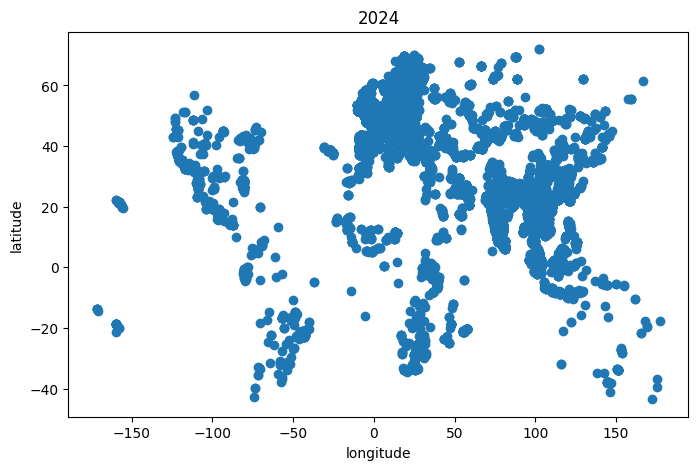

In [13]:
plt.figure(figsize=(8, 5))
plt.scatter(df_2024["longitude"], df_2024["latitude"])
plt.title("2024")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

Geographical Population of the Birds

In [14]:
fig = px.scatter_mapbox(df_2021,
                            lat="latitude",
                            lon="longitude",
#                             hover_data=["price"],
                            #color='rating',
                            zoom=0.7)


fig.update_layout(
       title = 'Birds Population',
#        geo_scope='usa',
        width=1000,
        height=600,
        mapbox_style="white-bg",
        mapbox_layers=[{
             "below": 'traces',
             "sourcetype": "raster",
             "sourceattribution": "United States Geological Survey",
             "source": ["https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"]
          }]
)

fig.update_geos(fitbounds="locations")
fig.show()

In [15]:
df_processed = df_2021.copy()

df_processed.head(5)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url
0,acafly,['amegfi'],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Empidonax virescens,Acadian Flycatcher,Mike Nelson,2012-08-12,XC109605.ogg,Creative Commons Attribution-NonCommercial-Sha...,2.5,09:30,https://www.xeno-canto.org/109605
1,acafly,[],['call'],9.1334,-79.6501,Empidonax virescens,Acadian Flycatcher,Allen T. Chartier,2000-12-26,XC11209.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,?,https://www.xeno-canto.org/11209
2,acafly,[],['call'],5.7813,-75.7452,Empidonax virescens,Acadian Flycatcher,Sergio Chaparro-Herrera,2012-01-10,XC127032.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,15:20,https://www.xeno-canto.org/127032
3,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129974.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129974
4,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129981.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129981


> Сразу трансформировать дату обычным способом не получилось:
```
df_processed['date'] = pd.to_datetime(df_processed['date'])
df_processed['time'] = pd.to_datetime(df_processed['time'], format="%H:%M")
```

 Из-за особенностей формата дат в таблице, придётся делать предобработку, которая будет приведена ниже

In [16]:
def date_format_check1(date_string):
    # это я проверял, что даты в целом по количеству цифр и символов заполнены правильно, в этом плане косяков не было
    result = 0
    if (len(date_string) != 10):
        result += 2000
    elif not (date_string[:4].isdigit() and date_string[5:7].isdigit() and date_string[8:].isdigit()
              and (date_string[4] == '-') and (date_string[7] == '-')):
        result +=1000
    return result

def date_format_check(date_string):
    # эта функция выявляет в базе косяки с годом, месяцем и днем, выдает 3-значное число, где 100 - признак косяка с годом,
    # 10 - признак косяка с месяцем, 1 - признак косяка с днем месяца
    result = 0
    year = int(date_string[:4])
    month = int(date_string[5:7])
    if month in [4, 6, 9, 11]:
        max_day_in_month = 30
    elif month == 2:
        if year % 4 == 0:
            max_day_in_month = 29
        else:
            max_day_in_month = 28
    else:
        max_day_in_month = 31
    day = int(date_string[8:])
    if year < 1900 or year > 2024:
        result += 100
    if month <=0 or month > 12:
        result += 10
    if day <= 0 or day > max_day_in_month:
        result += 1
    return result

# создаем служебный столбец - признак косяков в дате, его потом удалим
df_processed['check_data_format'] = df_processed['date'].apply(date_format_check)
# еще один столбец - признак того, что дата исправлялась. Его удалять не будем, при анализе данных по периодам можно будет по этому столбцу фильтровать
df_processed['date_was_corrected'] = df_processed['check_data_format'] > 0
df_processed.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url,check_data_format,date_was_corrected
0,acafly,['amegfi'],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Empidonax virescens,Acadian Flycatcher,Mike Nelson,2012-08-12,XC109605.ogg,Creative Commons Attribution-NonCommercial-Sha...,2.5,09:30,https://www.xeno-canto.org/109605,0,False
1,acafly,[],['call'],9.1334,-79.6501,Empidonax virescens,Acadian Flycatcher,Allen T. Chartier,2000-12-26,XC11209.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,?,https://www.xeno-canto.org/11209,0,False
2,acafly,[],['call'],5.7813,-75.7452,Empidonax virescens,Acadian Flycatcher,Sergio Chaparro-Herrera,2012-01-10,XC127032.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,15:20,https://www.xeno-canto.org/127032,0,False
3,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129974.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129974,0,False
4,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129981.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129981,0,False


In [17]:
# правим косяки с годами
# там, где дата вообще пропущена - ставим 01.01.1950 - это если что, будет самая ранняя дата в датасете, проще отфильтровать
df_processed.loc[df_processed['date'] == '0000-00-00',['date']] = '1950-01-01'
# в остальных строках с косячным годам исправляем предполагаемую опечатку (без гарантий, что правильно было именно так)
df_processed.loc[52100,['date']] = '1999-10-09'
df_processed.loc[54352,['date']] = '2014-10-11'
df_processed.loc[2668,['date']] = df_processed.loc[2668]['date'].replace('020', '200')
df_processed.loc[6433,['date']] = df_processed.loc[6433]['date'].replace('020', '200')
df_processed.loc[47979,['date']] = df_processed.loc[47979]['date'].replace('020', '200')
df_processed.loc[58264,['date']] = df_processed.loc[58264]['date'].replace('020', '200')

In [18]:
# исправление даты: где поставлен месяц 00, заменяем на 01, где число месяца 00, заменяем на 01
# в результате будет искусственно завышены наблюдения с датой 1 января, их потом можно отбросить по признаку date_was_corrected
def date_correction(date_string):
    return date_string.replace('-00-', '-01-').replace('-00', '-01')

condition = df_processed['check_data_format'] > 0
df_processed.loc[condition, 'date'] = df_processed.loc[condition, 'date'].apply(date_correction)

In [19]:
df_processed = df_processed.drop('check_data_format', axis = 1) # убираем служебный столбец с информацией о косяках в датах

In [20]:
# переводим даты в формат даты, если все косяки до этого поправили, должно отработать без ошибок
df_processed['date'] = pd.to_datetime(df_processed['date'])
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62874 entries, 0 to 62873
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   primary_label       62874 non-null  object        
 1   secondary_labels    62874 non-null  object        
 2   type                62874 non-null  object        
 3   latitude            62874 non-null  float64       
 4   longitude           62874 non-null  float64       
 5   scientific_name     62874 non-null  object        
 6   common_name         62874 non-null  object        
 7   author              62874 non-null  object        
 8   date                62874 non-null  datetime64[ns]
 9   filename            62874 non-null  object        
 10  license             62874 non-null  object        
 11  rating              62874 non-null  float64       
 12  time                62874 non-null  object        
 13  url                 62874 non-null  object    

In [21]:
def filter_data(df, longitude_left=-180, longitude_right=180, latitude_min=-90, latitude_max=90, beginning_month=1, end_month=12):
    # функция принимает датафрейм в формате соревнования 2021 года и возвращает датафрейм, в котором применены
    # фильтры по широте, долготе и сезону года
    if longitude_left <= longitude_right:
        mask_longitude = (df['longitude']>=longitude_left) & (df['longitude']<=longitude_right)
    else:
        mask_longitude = (df['longitude']>=longitude_left) | (df['longitude']<=longitude_right)
    mask_latitude = (df['latitude']>=latitude_min) & (df['latitude']<=latitude_max)
    if beginning_month <= end_month:
        mask_season = (df['date'].dt.month>=beginning_month) & (df['date'].dt.month<=end_month)
    else:
        mask_season = (df['date'].dt.month>=beginning_month) | (df['date'].dt.month<=end_month)
    df_result = df[mask_longitude & mask_latitude & mask_season]
    return df_result


# пример применения: хотим отфильтровать европейские наблюдения в зимний период:
df_filtered = filter_data(df_processed[~df_processed['date_was_corrected']],  # здесь исключаем строки, где вручную правили косяки с датами
                          longitude_left = -10, longitude_right = 30, latitude_min = 35
                         , beginning_month = 12, end_month = 2)
print(df_filtered.info())
df_filtered.head()

<class 'pandas.core.frame.DataFrame'>
Index: 827 entries, 4058 to 60439
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   primary_label       827 non-null    object        
 1   secondary_labels    827 non-null    object        
 2   type                827 non-null    object        
 3   latitude            827 non-null    float64       
 4   longitude           827 non-null    float64       
 5   scientific_name     827 non-null    object        
 6   common_name         827 non-null    object        
 7   author              827 non-null    object        
 8   date                827 non-null    datetime64[ns]
 9   filename            827 non-null    object        
 10  license             827 non-null    object        
 11  rating              827 non-null    float64       
 12  time                827 non-null    object        
 13  url                 827 non-null    object        

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url,date_was_corrected
4058,barswa,[],['call'],37.3823,-6.1363,Hirundo rustica,Barn Swallow,José Carlos Sires,2017-02-26,XC360600.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,?,https://www.xeno-canto.org/360600,False
4059,barswa,[],"['call', 'female', 'flight call', 'male', 'song']",36.4172,-6.1459,Hirundo rustica,Barn Swallow,José Carlos Sires,2017-02-27,XC361213.ogg,Creative Commons Attribution-NonCommercial-Sha...,4.0,?,https://www.xeno-canto.org/361213,False
4060,barswa,[],"['call', 'female', 'flight call', 'male', 'song']",36.4172,-6.1459,Hirundo rustica,Barn Swallow,José Carlos Sires,2017-02-27,XC361214.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,?,https://www.xeno-canto.org/361214,False
4061,barswa,[],"['call', 'female', 'flight call', 'male', 'song']",36.4172,-6.1459,Hirundo rustica,Barn Swallow,José Carlos Sires,2017-02-27,XC361215.ogg,Creative Commons Attribution-NonCommercial-Sha...,4.0,?,https://www.xeno-canto.org/361215,False
4062,barswa,[],"['call', 'female', 'flight call', 'male', 'song']",36.4172,-6.1459,Hirundo rustica,Barn Swallow,José Carlos Sires,2017-02-27,XC361216.ogg,Creative Commons Attribution-NonCommercial-Sha...,4.0,?,https://www.xeno-canto.org/361216,False


In [22]:
def time_correction(time_string):
    # Функция проверяет корректность формата времени, старается привести к единому формату чч.мм.сс,
    # если какая-то нестандартная ситуация, то возвращается "?", иначе возвращается строка в формате "чч.мм.сс"
    time_string = time_string.replace('AM','').replace('am','').strip() # убираем из времени "am"
    # если в строке есть 'pm', к часам надо добавить 12 и убрать 'pm'
    time_pm = False
    if time_string.find('PM') > 0 or time_string.find('pm') > 0:
        time_string = time_string.replace('PM','').replace('pm','').strip()
        time_pm = True
    time_parts = time_string.split(':')
    # прогоняем проверку, что часы, минуты и секунды - это нужное число цифр, и они не выходят за допустимый диапазон
    format_error = False
    if len(time_parts) < 2 or len(time_parts) > 3:
        format_error = True
    else:
        for i, str_part in enumerate(time_parts):
            if len(str_part) != 2 or (not str_part.isdigit()):
                # если час записан одной цифрой, добавляем впереди 0
                if i==0 and len(str_part) == 1 and str_part.isdigit():
                    time_string = '0' + time_string
                else:
                    format_error = True
            if not format_error:
                if (i==0 and int(str_part) > 23) or (1<=i<=2 and int(str_part) > 59):
                    format_error = True
        # если формат 'pm', добавляем к часам 12
        if time_pm and (not format_error) and int(time_string[:2]) < 12:
            time_string = str(int(time_string[:2]) + 12) + time_string[2:]
        # если в строке нет секунд, добавляем ":00" в конец
        if len(time_parts) == 2 and (not format_error):
            time_string += ':00'
    if format_error:
        return '?'
    else:
        return time_string

# создаем временный столбец со скорректированным значением времени
df_processed['time_corrected'] = df_processed['time'].apply(time_correction)
# создаем постоянный столбец с признаком того, что пропуски/опечатки во времени правились вручную
# это только для тех строк, которые процедура time_correction не смогла поправить
df_processed['time_was_corrected'] = df_processed['time_corrected']=='?'

# правим оставшиеся некорректные значения времени
df_processed.loc[df_processed['time']=='?', ['time_corrected']] = '00:00:01'
df_processed.loc[df_processed['time']=='.', ['time_corrected']] = '00:00:01'
df_processed.loc[df_processed['time']=='?:?', ['time_corrected']] = '00:00:01'
df_processed.loc[df_processed['time']=='??:??', ['time_corrected']] = '00:00:01'
df_processed.loc[df_processed['time']=='x', ['time_corrected']] = '00:00:01'
df_processed.loc[df_processed['time']=='xx.xx', ['time_corrected']] = '00:00:01'
df_processed.loc[df_processed['time']=='xx:xx', ['time_corrected']] = '00:00:01'
df_processed.loc[df_processed['time']=='xx;xx', ['time_corrected']] = '00:00:01'
df_processed.loc[df_processed['time']=='Night', ['time_corrected']] = '00:00:01'
df_processed.loc[df_processed['time']=='pm', ['time_corrected']] = '18:00:00'
df_processed.loc[df_processed['time']=='am', ['time_corrected']] = '06:00:00'
df_processed.loc[df_processed['time']=='Dawn', ['time_corrected']] = '06:00:00'
df_processed.loc[df_processed['time']=='008:15', ['time_corrected']] = '08:15:00'
df_processed.loc[df_processed['time']=='020:30', ['time_corrected']] = '20:30:00'
df_processed.loc[df_processed['time']=='24:15', ['time_corrected']] = '00:15:00'

# записываем в колонку со временем скорректированное время в формате datetime64
df_processed['time'] = pd.to_datetime(df_processed['time_corrected'], format="%H:%M:%S")
df_processed = df_processed.drop('time_corrected', axis = 1) # убираем временный столбец со скорректированным временем

# если отработало без ошибок, Time должно преобразоваться в формат datetime64
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62874 entries, 0 to 62873
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   primary_label       62874 non-null  object        
 1   secondary_labels    62874 non-null  object        
 2   type                62874 non-null  object        
 3   latitude            62874 non-null  float64       
 4   longitude           62874 non-null  float64       
 5   scientific_name     62874 non-null  object        
 6   common_name         62874 non-null  object        
 7   author              62874 non-null  object        
 8   date                62874 non-null  datetime64[ns]
 9   filename            62874 non-null  object        
 10  license             62874 non-null  object        
 11  rating              62874 non-null  float64       
 12  time                62874 non-null  datetime64[ns]
 13  url                 62874 non-null  object    

In [23]:
# Проверяем наличие дубликатов. Если выводится пустой список - дубликатов нет
duplicates = df_processed.duplicated()
duplicates[duplicates] # Выводим только строки, где значение строки = True, то есть, зафиксирован дубликат

,0


In [24]:
# удаляем из датафрейма столбцы, которые не будут использоваться при анализе данных
# df_processed.drop(columns=['secondary_labels', 'author', 'filename', 'license', 'rating', 'url'], inplace=True)

df_processed.drop(columns=['secondary_labels', 'author', 'license', 'rating'], inplace=True)

In [25]:
# сохраняем обработанный датафрейм в новый файл
df_processed.to_csv('data_2021_corrected.csv', index=False)

In [26]:
# открываем новый файл, смотрим, что получилось
df_processed = pd.read_csv("data_2021_corrected.csv")
# распознавание даты-времени надо делать заново при каждом открытии из csv
df_processed['date'] = pd.to_datetime(df_processed['date'])
df_processed['time'] = pd.to_datetime(df_processed['time'], format="%Y-%m-%d %H:%M:%S")
df_processed.head()

,primary_label,type,latitude,longitude,scientific_name,common_name,date,filename,time,url,date_was_corrected,time_was_corrected
0,acafly,"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Empidonax virescens,Acadian Flycatcher,2012-08-12,XC109605.ogg,1900-01-01 09:30:00,https://www.xeno-canto.org/109605,False,False
1,acafly,['call'],9.1334,-79.6501,Empidonax virescens,Acadian Flycatcher,2000-12-26,XC11209.ogg,1900-01-01 00:00:01,https://www.xeno-canto.org/11209,False,True
2,acafly,['call'],5.7813,-75.7452,Empidonax virescens,Acadian Flycatcher,2012-01-10,XC127032.ogg,1900-01-01 15:20:00,https://www.xeno-canto.org/127032,False,False
3,acafly,['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,2009-06-19,XC129974.ogg,1900-01-01 07:50:00,https://www.xeno-canto.org/129974,False,False
4,acafly,['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,2009-06-19,XC129981.ogg,1900-01-01 07:50:00,https://www.xeno-canto.org/129981,False,False


In [27]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62874 entries, 0 to 62873
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   primary_label       62874 non-null  object        
 1   type                62874 non-null  object        
 2   latitude            62874 non-null  float64       
 3   longitude           62874 non-null  float64       
 4   scientific_name     62874 non-null  object        
 5   common_name         62874 non-null  object        
 6   date                62874 non-null  datetime64[ns]
 7   filename            62874 non-null  object        
 8   time                62874 non-null  datetime64[ns]
 9   url                 62874 non-null  object        
 10  date_was_corrected  62874 non-null  bool          
 11  time_was_corrected  62874 non-null  bool          
dtypes: bool(2), datetime64[ns](2), float64(2), object(6)
memory usage: 4.9+ MB


In [28]:
def filter_data(df, bird='',
                longitude_left=-180, longitude_right=180,
                latitude_min=-90, latitude_max=90,
                beginning_month=1, end_month=12):
    # функция принимает датафрейм в формате соревнования 2021 года и возвращает датафрейм, в котором применены
    # фильтры по коду птиц (либо единственный вид, либо все виды сразу), широте, долготе и сезону года
    if bird == '':
        mask_bird = True
    else:
        mask_bird = df['primary_label'] == bird
    if longitude_left <= longitude_right:
        mask_longitude = (df['longitude']>=longitude_left) & (df['longitude']<=longitude_right)
    else:
        mask_longitude = (df['longitude']>=longitude_left) | (df['longitude']<=longitude_right)
    mask_latitude = (df['latitude']>=latitude_min) & (df['latitude']<=latitude_max)
    if beginning_month <= end_month:
        mask_season = (df['date'].dt.month>=beginning_month) & (df['date'].dt.month<=end_month)
    else:
        mask_season = (df['date'].dt.month>=beginning_month) | (df['date'].dt.month<=end_month)
    df_result = df[mask_bird & mask_longitude & mask_latitude & mask_season]
    return df_result

# пример применения: хотим отфильтровать европейские наблюдения в зимний период:
df_filtered = filter_data(df_processed[~df_processed['date_was_corrected']], # здесь исключаем строки, где вручную правили косяки с датами
                          bird='tunswa', longitude_left=-10, longitude_right=30, latitude_min=35
                         , beginning_month=12, end_month=2)
print(df_filtered.info())
df_filtered.head()

<class 'pandas.core.frame.DataFrame'>
Index: 27 entries, 54958 to 55043
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   primary_label       27 non-null     object        
 1   type                27 non-null     object        
 2   latitude            27 non-null     float64       
 3   longitude           27 non-null     float64       
 4   scientific_name     27 non-null     object        
 5   common_name         27 non-null     object        
 6   date                27 non-null     datetime64[ns]
 7   filename            27 non-null     object        
 8   time                27 non-null     datetime64[ns]
 9   url                 27 non-null     object        
 10  date_was_corrected  27 non-null     bool          
 11  time_was_corrected  27 non-null     bool          
dtypes: bool(2), datetime64[ns](2), float64(2), object(6)
memory usage: 2.4+ KB
None


,primary_label,type,latitude,longitude,scientific_name,common_name,date,filename,time,url,date_was_corrected,time_was_corrected
54958,tunswa,"['call', 'juvenile']",52.3076,5.2597,Cygnus columbianus,Tundra Swan,2012-12-08,XC119510.ogg,1900-01-01 14:00:00,https://www.xeno-canto.org/119510,False,False
54959,tunswa,['call'],53.0889,4.8244,Cygnus columbianus,Tundra Swan,2013-02-08,XC122565.ogg,1900-01-01 17:00:00,https://www.xeno-canto.org/122565,False,False
54963,tunswa,['flight call'],51.6228,5.8293,Cygnus columbianus,Tundra Swan,2014-01-10,XC164280.ogg,1900-01-01 11:00:00,https://www.xeno-canto.org/164280,False,False
54977,tunswa,['flight call'],52.7182,0.3492,Cygnus columbianus,Tundra Swan,2009-12-29,XC310765.ogg,1900-01-01 12:00:00,https://www.xeno-canto.org/310765,False,False
54984,tunswa,['flight call'],43.6028,4.5540,Cygnus columbianus,Tundra Swan,2017-02-26,XC357196.ogg,1900-01-01 08:00:00,https://www.xeno-canto.org/357196,False,False


In [29]:
import datetime

def species_count(df, longitude_left=-180, longitude_right=180,
                  latitude_min=-90, latitude_max=90,
                  beginning_month=1, end_month=12):
    # функция выдает датафрейм с количеством разных видов птиц по годам, которые встречаются в базе, с учетом фильтров
    # по локации и сезону
    df_filtered = filter_data(df_processed[~df_processed['date_was_corrected']] # здесь исключаем строки, где вручную правили косяки с датами
                          , longitude_left = longitude_left, longitude_right = longitude_right, latitude_min = latitude_min
                          , latitude_max =latitude_max, beginning_month = beginning_month, end_month = end_month)
    # тут, наверное, можно как-то не так криво. Смысл - сначала группируем данные по году и видам, потом повторно группируем только по годам,
        # с подсчетом количества уникальных видов в каждом годе
    result = df_filtered.groupby([lambda x: df_filtered.loc[x]['date'].year, 'primary_label']).agg({'latitude': 'count'}).reset_index() \
                .groupby('level_0').agg({'primary_label': 'count'}).reset_index()
    result.columns = ["year", "number_of_species"]
    return result

df_species_count = species_count(df_processed[~df_processed['date_was_corrected']], # здесь исключаем строки, где вручную правили косяки с датами
                          longitude_left = -10, longitude_right = 30, latitude_min = 35
                         , beginning_month = 1, end_month = 12)
df_species_count

,year,number_of_species
0,1967,1
1,1968,1
2,1971,1
3,1972,1
4,1977,1
5,1978,1
6,1979,1
7,1982,6
8,1983,4
9,1985,1


> Мне кажется, для вывода каких-то результатов могут быть полезны 2 функции в конце ноутбука - первая фильтрует базу по заданным критериям по локации и сезонности, вторая выдает подсчет количества уникальных видов птиц по годам по отфильтрованной базе.
Это мне кажется, можно как-то соединять с пользовательским интерфейсом и визуализацией исходящих данных

In [30]:
import datetime

def species_count(df, longitude_left=-180, longitude_right=180,
                  latitude_min=-90, latitude_max=90,
                  beginning_month=1, end_month=12):
    # функция выдает датафрейм с количеством разных видов птиц по годам, которые встречаются в базе, с учетом фильтров
    # по локации и сезону
    df_filtered = filter_data(df_processed[~df_processed['date_was_corrected']] # здесь исключаем строки, где вручную правили косяки с датами
                          , longitude_left = longitude_left, longitude_right = longitude_right, latitude_min = latitude_min
                          , latitude_max =latitude_max, beginning_month = beginning_month, end_month = end_month)
    # Группируем данные по году с подсчетом количества уникальных видов в каждом годе
    result = df_filtered.groupby(lambda x: df_filtered.loc[x]['date'].year).agg({'primary_label': 'nunique'}).reset_index()
    result.columns = ["year", "number_of_species"]
    return result

df_species_count = species_count(df_processed[~df_processed['date_was_corrected']], # здесь исключаем строки, где вручную правили косяки с датами
                          longitude_left = -10, longitude_right = 30, latitude_min = 35
                         , beginning_month = 1, end_month = 12)
df_species_count

,year,number_of_species
0,1967,1
1,1968,1
2,1971,1
3,1972,1
4,1977,1
5,1978,1
6,1979,1
7,1982,6
8,1983,4
9,1985,1


In [31]:
import datetime

def bird_dynamics(df, bird='', longitude_left=-180, longitude_right=180,
                  latitude_min=-90, latitude_max=90,
                  beginning_month=1, end_month=12):
    # функция выдает датафрейм с динамикой количества записей конкретного вида птиц, которые встречаются в базе,
    # с учетом фильтров по локации и сезону

    # описание полей результирующего датафрейма:
    # 1) year: год наблюдений;
    # 2) number_of_records_in_database: количество записей в исходном датафрейме по всем видам птиц за указанный год
    #     с учетом фильтров по локации и сезонности;
    # 3) records_of_the_bird: количество записей в исходном датафрейме по заданному виду птиц за указанный год
    #    с учетом фильтров по локации и сезонности;
    # 4) frequency: относительная частота записей данного вида в общем количестве записей, единиц на тысячу записей;
    # 5) mov_avg_total: скользящее среднее за 3 года по количеству записей в исходном датафрейме по всем видам птиц
    #     с учетом фильтров по локации и сезонности;
    # 6) mov_avg_bird: скользящее среднее за 3 года по количеству записей в исходном датафрейме по заданному виду птиц
    #     с учетом фильтров по локации и сезонности;
    # 7) mov_avg_frequency: относительная частота записей данного вида в общем количестве записей, рассчитанная по скользящим средним
    #     за 3 года,  единиц на тысячу записей;
    # 8) risk_of_exstinction: оценка риска депопуляции данного вида. Принимает 1 из 4 значений:
    #     а) "серый" - если недостаточно данных для каких-либо выводов;
    #     б) "зеленый" - низкий риск: колебания количества записей данного вида и его частоты не перешли заданное пороговое значение;
    #     в) "желтый" - средний риск: по одному из двух показателей пробит порог (либо падение количества записей для вида, либо падение частоты);
    #     г) "красный" - высокий риск: по обоим показателям пробиты пороговые значения (и падение количества, и падение частоты)


    # задаем пороговые значения, при невыполнении которых уровень риска исчезновения популяции птиц относится к серой зоне
    min_records_in_database = 40 # мин. общее количество записей с учетом фильтров
    min_mov_avg_or_bird_counts = 3 # мин. кол-во записей данного вида по средневзвешенной за 3 года
    threshold_drop_in_counts = 0.7 # отношение записей вида в данном году к средневзвешенному за 3 года, ниже которого срабатывает алерт
    threshold_drop_in_frequency = 0.8 # отношение частоты записей вида в данном году к средневзвешенному за 3 года, ниже которого срабатывает алерт

    if bird == '': # если вид птицы не указан - прекращаем работу функции
        print('Необходимо указать код птицы (primary_label)!')
        return
    # Фильтруем данные для подсчета количества записей по всем видам в каждом годе
    df_filtered = filter_data(df_processed[~df_processed['date_was_corrected']] # здесь исключаем строки, где вручную правили косяки с датами
                          , longitude_left = longitude_left, longitude_right = longitude_right, latitude_min = latitude_min
                          , latitude_max =latitude_max, beginning_month = beginning_month, end_month = end_month)
    if len(df_filtered)==0: # если по фильтру ничего не найдено - прекращаем работу функции
        print('Данные с указанными параметрами не обнаружены')
        return
    # Группируем данные по году с подсчетом количества записей по всем видам в каждом годе
    df_total_records = df_filtered.groupby(lambda x: df_filtered.loc[x]['date'].year).agg({'latitude': 'count'}).reset_index()
    df_total_records.columns = ["year", "number_of_records_in_database"]
    # Фильтруем и группируем данные по году с подсчетом количества записей по конкретному виду птиц в каждом годе
    df_filtered = filter_data(df_processed[~df_processed['date_was_corrected']] # здесь исключаем строки, где вручную правили косяки с датами
                          , bird = bird
                          , longitude_left = longitude_left, longitude_right = longitude_right, latitude_min = latitude_min
                          , latitude_max =latitude_max, beginning_month = beginning_month, end_month = end_month)
    df_bird_records = df_filtered.groupby(lambda x: df_filtered.loc[x]['date'].year).agg({'latitude': 'count'}).reset_index()
    df_bird_records.columns = ["year", "records_of_the_bird"]
    # объединяем два датасета по полю год
    df_result = df_total_records.join(df_bird_records.set_index('year'), on='year')
    df_result = df_result.fillna(0)
    df_result['records_of_the_bird'] = df_result['records_of_the_bird'].astype(int) # после исправления nan восстанавливаем тип данных int
    # считаем относительную частоту записей с данным видом птиц (единиц на тысячу записей)
    df_result['frequency'] = df_result['records_of_the_bird'] / df_result['number_of_records_in_database'] * 1000
    # служебные переменные и словари для дальнейшего анализа
    first_year = df_result['year'].min()
    last_year = df_result['year'].max()
    dict_total = df_result.set_index('year')['number_of_records_in_database'].to_dict()
    dict_bird = df_result.set_index('year')['records_of_the_bird'].to_dict()
    for i in range(first_year, last_year + 1):
        if dict_total.get(i) is None:
            dict_total[i] = 0
            dict_bird[i] = 0
    years_list = list(df_result['year'])
    # создаем колонки для дальнейшего заполнения со значениями по умолчанию
    df_result['mov_avg_total'] = df_result['number_of_records_in_database'].astype(float)
    df_result['mov_avg_bird'] = df_result['records_of_the_bird'].astype(float)
    df_result['mov_avg_frequency'] = df_result['frequency']
    df_result['risk_of_exstinction'] = 'gray'
    # заполняем колонки результирующего датафрейма (цикл по всем строкам)
    for i in range(df_result.shape[0]):
        if i < 2: # для первых двух строк средневзвешенные не считаются
            df_result.loc[i,['mov_avg_total']] = 0
            df_result.loc[i,['mov_avg_bird']] = 0
            df_result.loc[i,['mov_avg_frequency']] = 0
        else:
            year_number = df_result.loc[i]['year']
            # считаем средневзвешенные за 3 года
            df_result.loc[i,['mov_avg_total']] = (dict_total[year_number] + dict_total[year_number-1] + dict_total[year_number-2]) / 3
            ma_birds = (dict_bird[year_number] + dict_bird[year_number-1] + dict_bird[year_number-2]) / 3
            df_result.loc[i,['mov_avg_bird']] = ma_birds
            ma_frequency = df_result.loc[i]['mov_avg_bird'] / df_result.loc[i]['mov_avg_total'] * 1000
            df_result.loc[i,['mov_avg_frequency']] = ma_frequency
            # оцениваем показатель риска - проверяем на пробитие порогов
            if (dict_total[year_number] >= min_records_in_database) and (ma_birds >= min_mov_avg_or_bird_counts):
                if dict_bird[year_number] / ma_birds <= threshold_drop_in_counts:
                    if df_result.loc[i]['frequency'] / ma_frequency <= threshold_drop_in_frequency:
                        df_result.loc[i,['risk_of_exstinction']] = 'red'
                    else:
                        df_result.loc[i,['risk_of_exstinction']] = 'yellow'
                else:
                    if df_result.loc[i]['frequency'] / ma_frequency <= threshold_drop_in_frequency:
                        df_result.loc[i,['risk_of_exstinction']] = 'yellow'
                    else:
                        df_result.loc[i,['risk_of_exstinction']] = 'green'

    return df_result

# пример использования функции: выводим данные по tunswa с фильтром на примерно европейскую широту и долготу
df_bird_dynamics = bird_dynamics(df_processed[~df_processed['date_was_corrected']], # здесь исключаем строки, где вручную правили косяки с датами
                          bird = 'tunswa', longitude_left = -10, longitude_right = 30, latitude_min = 35
                         , beginning_month = 1, end_month = 12)
df_bird_dynamics

,year,number_of_records_in_database,records_of_the_bird,frequency,mov_avg_total,mov_avg_bird,mov_avg_frequency,risk_of_exstinction
0,1967,1,0,0.000000,0.000000,0.000000,0.000000,gray
1,1968,1,0,0.000000,0.000000,0.000000,0.000000,gray
2,1971,1,0,0.000000,0.333333,0.000000,0.000000,gray
3,1972,1,0,0.000000,0.666667,0.000000,0.000000,gray
4,1977,1,0,0.000000,0.333333,0.000000,0.000000,gray
5,1978,1,0,0.000000,0.666667,0.000000,0.000000,gray
6,1979,2,0,0.000000,1.333333,0.000000,0.000000,gray
7,1982,11,0,0.000000,3.666667,0.000000,0.000000,gray
8,1983,5,0,0.000000,5.333333,0.000000,0.000000,gray
9,1985,1,0,0.000000,2.000000,0.000000,0.000000,gray


### [ Musa ]

<Axes: >

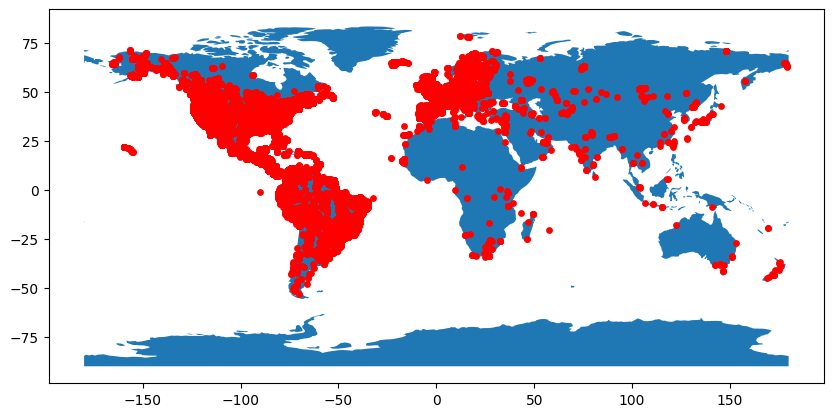

In [ ]:
# смотрим распределение гео птиц за 2021
geometry = [Point(xy) for xy in zip(df_2021['longitude'], df_2021['latitude'])]
gdf = GeoDataFrame(df_2021, geometry=geometry)

world = gpd.read_file(geodatasets.data.naturalearth.land['url'])
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)

In [ ]:
# смотрим распределение рейтинга аудио
fig = px.histogram(df_2021, x="rating", nbins=len(df_2021["rating"].unique()) )
fig.update_layout(title_text="Распределение рейтинга аудио")
fig.show()

> В данных присутствует рейтинг 0 - возможно, валидатор не смог корректно распознать аудио

<ipython-input-36-39066c44fd24>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




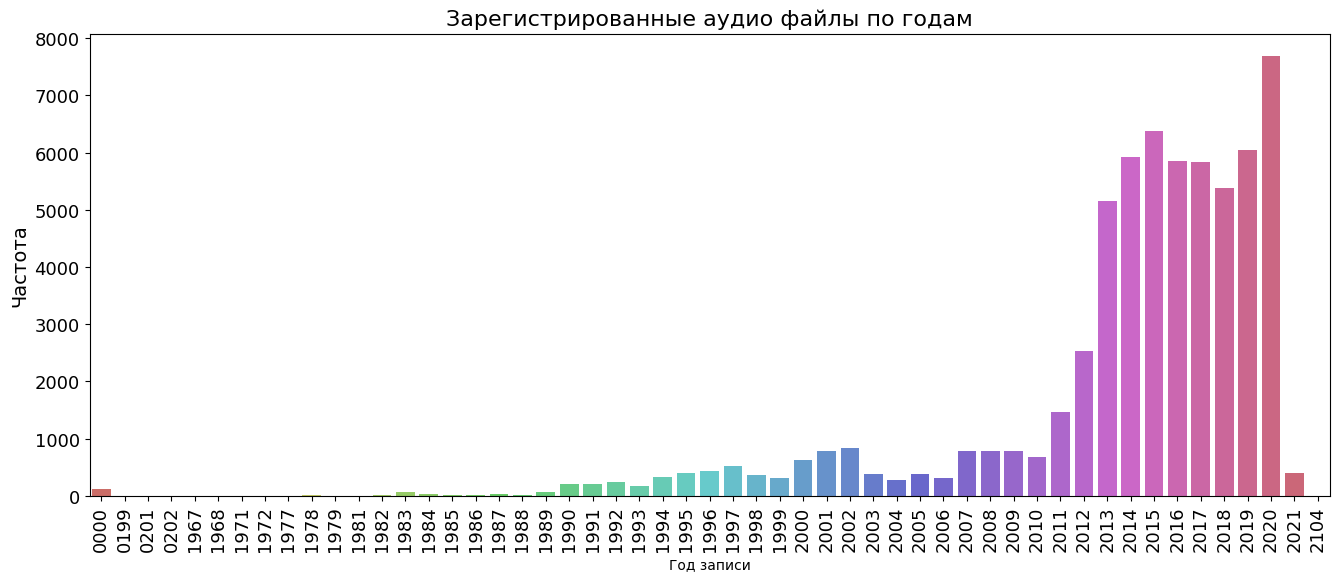

In [ ]:
# Проверим распределение зарегистрированных аудио файлов по годам
year_uploaded = df_2021['date'].apply(lambda x: x.split('-')[0])

plt.figure(figsize=(16, 6))
ax = sns.countplot(x=year_uploaded.sort_values().values, palette="hls")

plt.title("Зарегистрированные аудио файлы по годам", fontsize=16)
plt.xticks(rotation=90, fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel("Частота", fontsize=14)
plt.xlabel("Год записи");

> Большая часть записей загружена в период с 2012 по 2020 год

> Также стоит обратить внимание, что некоторые годы указаны неверно (например: 2104, 0199, 2104 и т. п.).

<ipython-input-37-593f63ce7c43>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




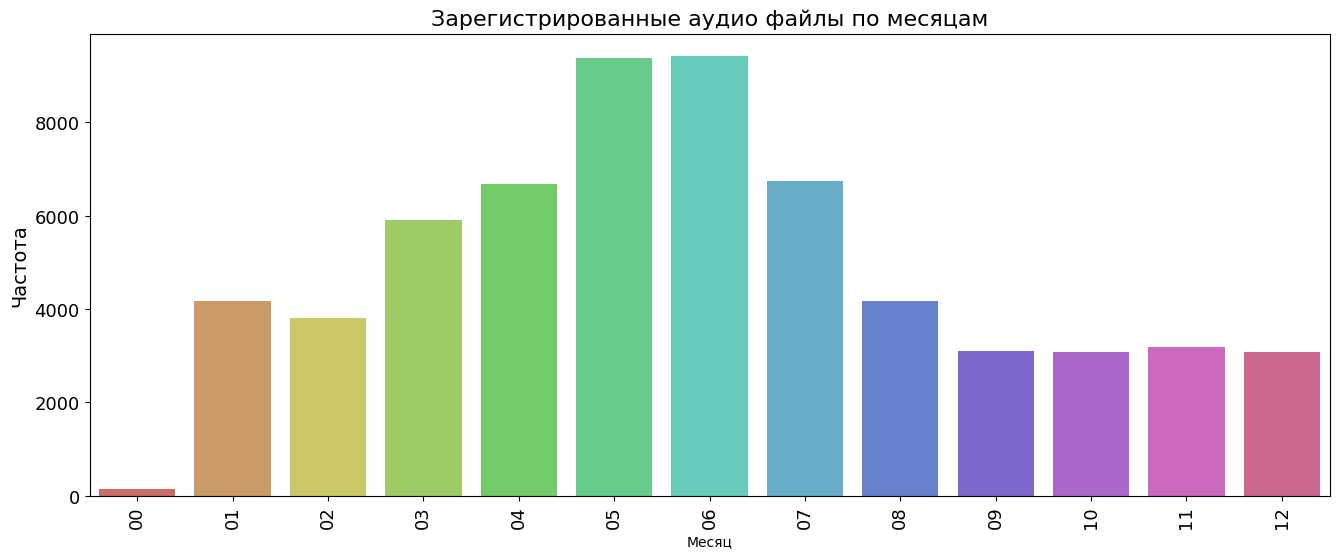

In [ ]:
# Проверим распределение зарегистрированных аудио файлов по месяцам
month_uploaded = df_2021['date'].apply(lambda x: x.split('-')[1])

plt.figure(figsize=(16, 6))
ax = sns.countplot(x=month_uploaded.sort_values().values, palette="hls")

plt.title("Зарегистрированные аудио файлы по месяцам", fontsize=16)
plt.xticks(rotation=90, fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel("Частота", fontsize=14)
plt.xlabel("Месяц");

> Больше всего записей было сделано с апреля по август (00-неправильная запись даты в датасете)

In [ ]:
species = df_2021['primary_label'].value_counts()

# Make bar chart
fig = go.Figure(data=[go.Bar(y=species.values, x=species.index)],
                layout=go.Layout(margin=go.layout.Margin(l=0, r=0, b=10, t=50)))

# Show chart
fig.update_layout(title='Количество аудиосемплов по видам птиц 2021')
fig.show()

> Это несбалансированный набор данных. У некоторых видов имеется 500 образцов, а у многих менее 100

In [ ]:
species = df_2024['primary_label'].value_counts()

# Make bar chart
fig = go.Figure(data=[go.Bar(y=species.values, x=species.index)],
                layout=go.Layout(margin=go.layout.Margin(l=0, r=0, b=10, t=50)))

# Show chart
fig.update_layout(title='Количество аудиосемплов по видам птиц 2024')
fig.show()

> В аудиосемплах за 2024 год видно отличие от распределения данных за 2021 год- возможно, при соединении двух датасетов это положительно скажется на итоговом распределении аудиосемплов

## Perch Model Tests

> Используем предобученную модель классификации птиц по аудио записям:

https://www.kaggle.com/models/google/bird-vocalization-classifier/tensorFlow2/bird-vocalization-classifier v4

In [32]:
import numpy as np
import librosa
from tqdm import tqdm
import tensorflow as tf
import tensorflow_hub as hub

In [33]:
# загружаем модель
model_url = 'https://kaggle.com/models/google/bird-vocalization-classifier/frameworks/tensorFlow2/variations/bird-vocalization-classifier/versions/4'
            # 'https://kaggle.com/models/google/bird-vocalization-classifier/TensorFlow2/bird-vocalization-classifier'
model = hub.load(model_url)

# таблица с видами птиц
# результатом работы модели для записи является индекс вида из этой таблицы
labels_path = hub.resolve(model_url) + "/assets/label.csv"
df_model_labels = pd.read_csv(labels_path) # коды видов птиц, на которых обучена модель

In [34]:
df_model_labels

,ebird2021
0,aakspa1
1,abbbab1
2,abbboo2
3,abbsta2
4,abbwar1
...,...
10927,zimwoo2
10928,zitcis1
10929,zittyr1
10930,zoeimp1


In [35]:
print('Виды птиц 2021 года, которых нет в предобученной модели: ')
print(df_unique_2021[~df_unique_2021['primary_label'].isin(df_model_labels['ebird2021'])])
print()
print('Виды птиц 2024 года, которых нет в предобученной модели: ')
print(df_unique_2024[~df_unique_2024['primary_label'].isin(df_model_labels['ebird2021'])])

Виды птиц 2021 года, которых нет в предобученной модели: 
    primary_label
146        gnwtea
153       grasal1
166        grnjay
172        heptan
265       reevir1

Виды птиц 2024 года, которых нет в предобученной модели: 
   primary_label
12       bkrfla1
86       indrol2


In [36]:
# количество записей в данных для видов, которых нет в предобученной модели
print('Количество записей в данных для видов из 2021, которых нет в предобученной модели: ')
values_to_check = ['gnwtea', 'grasal1', 'grnjay', 'heptan', 'reevir1']
display(df_2021[df_2021['primary_label'].isin(values_to_check)]['primary_label'].value_counts())
print()
print('Количество записей в данных для видов из 2024, которых нет в предобученной модели: ')
values_to_check = ['bkrfla1', 'indrol2']
display(df_2024[df_2024['primary_label'].isin(values_to_check)]['primary_label'].value_counts())

Количество записей в данных для видов из 2021, которых нет в предобученной модели: 


,count
primary_label,
grasal1,289
gnwtea,280
reevir1,200
grnjay,133
heptan,22



Количество записей в данных для видов из 2024, которых нет в предобученной модели: 


,count
primary_label,
indrol2,35
bkrfla1,29


Количество записей в данных для видов из 2021, которых нет в предобученной модели:  
primary_label  
grasal1    289  
gnwtea     280  
reevir1    200  
grnjay     133  
heptan      22  
Name: count, dtype: int64  

Количество записей в данных для видов из 2024, которых нет в предобученной модели:   
primary_label  
indrol2    35  
bkrfla1    29  
Name: count, dtype: int64  


In [ ]:
!kaggle competitions download -c birdclef-2024 --file "train_audio/asbfly/XC134896.ogg" --path data/BirdCLEF-2024/train_audio/asbfly

  0% 0.00/192k [00:00<?, ?B/s]
100% 192k/192k [00:00<00:00, 93.3MB/s]


Потренируемся делать предсказание для одной записи:  

In [ ]:
df_model_labels.to_csv('labels.csv', index=False)

In [ ]:
model.infer_tf(framed_audio[0:1])
  # получаем прогноз для первого фрейма

(<tf.Tensor: shape=(1, 10932), dtype=float32, numpy=
 array([[-17.696625, -14.30632 , -19.455826, ..., -17.62301 , -22.303556,
         -15.911839]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1280), dtype=float32, numpy=
 array([[-0.01695841, -0.14812668,  0.01556512, ...,  0.05336275,
          0.11476047,  0.01612443]], dtype=float32)>)

In [ ]:
# функция меняет sample rate. Это нужно, так как модель обучена на 32000 Hz
def resample_rate(audio, sample_rate, new_sample_rate=32000):
    if sample_rate != new_sample_rate:
        audio = librosa.resample(audio, orig_sr=sample_rate, target_sr=new_sample_rate)
    return audio, new_sample_rate

# функция разбивает запись на фреймы по 5 секунд, так как модель обучена на работе с 5 секундными записями
def break_into_frames(audio, sample_rate, window_size=5.0, step_size=5.0) -> np.ndarray:
    frame_length = int(window_size * sample_rate)
    frame_step  = int(step_size * sample_rate)
    framed_audio = tf.signal.frame(audio, frame_length, frame_step, pad_end=True)  # разбитое на фреймы аудио
    return framed_audio


# получим предсказание для первого фрейма одной записи
audio, sample_rate = librosa.load("data/BirdCLEF-2024/train_audio/asbfly/XC134896.ogg")

audio, sample_rate = resample_rate(audio, sample_rate)
framed_audio = break_into_frames(audio, sample_rate)  # разбитое на фреймы аудио

logits, embeddings = model.infer_tf(framed_audio[0:1])  # получаем прогноз для первого фрейма
embeddings = tf.nn.softmax(logits)

# embeddings = model.infer_tf(framed_audio[0:1])['embedding']  # получаем прогноз для первого фрейма

argmax = np.argmax(embeddings)
birds_kind = df_model_labels.iloc[argmax]['ebird2021']
probability = embeddings[0][argmax]
print(f"Предсказанный вид птицы по первому фрейму: {birds_kind}, с вероятностью: {probability}")


# будем получать вероятность для записи как максимальную вероятность среди фреймов, на которые разбита запись
def predict_for_framed_audio(framed_audio):
    birds_kind = None
    max_probability = 0
    i = 0
    while i + 1 <= framed_audio.shape[0]:
        logits, embeddings = model.infer_tf(framed_audio[i:i+1])
        embeddings = tf.nn.softmax(logits)

        # embeddings = model.infer_tf(framed_audio[0:1])['embedding']

        argmax = np.argmax(embeddings)
        probability = embeddings[0][argmax]
        if (probability > max_probability):
            max_probability = probability
            birds_kind = df_model_labels.iloc[argmax]['ebird2021']
        i += 1
    return birds_kind, max_probability


birds_kind, probability = predict_for_framed_audio(framed_audio)
print(f"Предсказанный вид птицы по всей записи: {birds_kind}, с вероятностью: {probability}")

Предсказанный вид птицы по первому фрейму: asbfly, с вероятностью: 0.9992825388908386
Предсказанный вид птицы по всей записи: asbfly, с вероятностью: 0.9999480247497559


In [ ]:
# функция меняет sample rate. Это нужно, так как модель обучена на 32000 Hz
def resample_rate(audio, sample_rate, new_sample_rate=32000):
    if sample_rate != new_sample_rate:
        audio = librosa.resample(audio, orig_sr=sample_rate, target_sr=new_sample_rate)
    return audio, new_sample_rate

# функция разбивает запись на фреймы по 5 секунд, так как модель обучена на работе с 5 секундными записями
def break_into_frames(audio, sample_rate, window_size=5.0, step_size=5.0) -> np.ndarray:
    frame_length = int(window_size * sample_rate)
    frame_step  = int(step_size * sample_rate)
    framed_audio = tf.signal.frame(audio, frame_length, frame_step, pad_end=True) # разбитое на фреймы аудио
    return framed_audio

# получим предсказание для первого фрейма одной записи
audio, sample_rate = librosa.load("data/BirdCLEF-2024/train_audio/asbfly/XC134896.ogg")

audio, sample_rate = resample_rate(audio, sample_rate)
framed_audio = break_into_frames(audio, sample_rate) # разбитое на фреймы аудио

logits, embeddings = model.infer_tf(framed_audio[0:1]) # получаем прогноз для первого фрейма
embeddings = tf.nn.softmax(logits)
argmax = np.argmax(embeddings)
birds_kind = df_model_labels.iloc[argmax]['ebird2021']
probability = embeddings[0][argmax]
print(f"Предсказанный вид птицы по первому фрейму: {birds_kind}, с вероятностью: {probability}")

# будем получать вероятность для записи как максимальную вероятность среди фреймов, на которые разбита запись
def predict_for_framed_audio(framed_audio):
    birds_kind = None
    max_probability = 0
    i = 0
    while i + 1 <= framed_audio.shape[0]:
        logits, embeddings = model.infer_tf(framed_audio[i:i+1])
        embeddings = tf.nn.softmax(logits)
        argmax = np.argmax(embeddings)
        probability = embeddings[0][argmax]
        if (probability > max_probability):
            max_probability = probability
            birds_kind = df_model_labels.iloc[argmax]['ebird2021']
        i += 1
    return birds_kind, max_probability

birds_kind, probability = predict_for_framed_audio(framed_audio)
print(f"Предсказанный вид птицы по всей записи: {birds_kind}, с вероятностью: {probability}")

Предсказанный вид птицы по первому фрейму: asbfly, с вероятностью: 0.9992825388908386
Предсказанный вид птицы по всей записи: asbfly, с вероятностью: 0.9999480247497559


Сделаем предсказание по всему набору записей за 2024 год и получим метрики модели.  

In [ ]:
from sklearn.metrics import accuracy_score

path_audio = 'data/2024/birdclef-2024/train_audio/'
list_test = list(path_audio + df_2024['filename'])

list_test = list_test[250:350] # для теста, чтобы не на всём наборе данных !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# функция возвращает предсказание для всех аудио записей из входящего списка
def get_predicts(list_test):
    df_predictions = pd.DataFrame(columns=['PATH', 'birds_kind', 'probability', 'error_text'])
    for audio_path in tqdm(list_test):
        try:
            audio, sample_rate = librosa.load(audio_path)
            audio, sample_rate = resample_rate(audio, sample_rate)
            framed_audio = break_into_frames(audio, sample_rate) # разбитое на фреймы аудио
            birds_kind, probability = predict_for_framed_audio(framed_audio)
            new_data = pd.DataFrame({'PATH': audio_path, 'birds_kind': birds_kind, 'probability': float(probability), 'error_text': None}, index=[0])
            df_predictions = pd.concat([df_predictions, new_data], ignore_index=True)
        except Exception as e:
            new_data = pd.DataFrame({'PATH': audio_path, 'birds_kind': None, 'probability': None, 'error_text': e}, index=[0])
            df_predictions = pd.concat([df_predictions, new_data], ignore_index=True)
    return df_predictions

# получаем dataFrame с предсказаниями
df_predictions = get_predicts(list_test)

# найдём в исходном датасете за 2024 год правильные значения видов птиц и сравним с предсказаниями.
temp_df = df_2024.copy()
temp_df['PATH'] = path_audio + temp_df['filename']
result_df = pd.merge(temp_df, df_predictions, on='PATH', how='inner')
result_df = result_df[['primary_label', 'PATH', 'birds_kind', 'probability', 'error_text']]

# получим метрику
y_true = result_df['primary_label'].tolist()
y_pred = result_df['birds_kind'].tolist()
accuracy = accuracy_score(y_true, y_pred)
print('accuracy_score: ',accuracy)



  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\N\AppData\Local\Temp\ipykernel_10316\443125018.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_predictions = pd.concat([df_predictions, new_data], ignore_index=True)
100%|██████████| 100/100 [05:12<00:00,  3.12s/it]

accuracy_score:  0.94


## Data Preparation

In [37]:
# Отберем виды, у которых представлено более 300 сэмплов

species_counts = df_processed['primary_label'].value_counts()

species_counts = species_counts[species_counts >= 300]

print(len(species_counts))

# Make bar chart
fig = go.Figure(data=[go.Bar(y=species_counts.values, x=species_counts.index)],
                layout=go.Layout(margin=go.layout.Margin(l=0, r=0, b=10, t=50)))

# Show chart
fig.update_layout(title='Количество аудиосемплов по видам птиц 2021')
fig.show()

39


In [38]:
species_counts.index

Index(['redcro', 'comrav', 'houspa', 'norcar', 'barswa', 'houwre', 'sonspa',
       'gbwwre1', 'eursta', 'spotow', 'cubthr', 'rewbla', 'mallar3', 'amerob',
       'bewwre', 'carwre', 'swathr', 'rubpep1', 'bncfly', 'rucspa1', 'comyel',
       'warvir', 'eucdov', 'daejun', 'grekis', 'wbwwre1', 'whimbr', 'marwre',
       'normoc', 'roahaw', 'bcnher', 'blujay', 'wesmea', 'whbnut', 'whcspa',
       'banana', 'lobgna5', 'ducfly', 'yeofly1'],
      dtype='object', name='primary_label')

In [39]:
# Фильтруем исходный DataFrame
filtered_df = df_processed[df_processed['primary_label'].isin(species_counts.index)]

# filtered_df

In [40]:
# Группируем по 'primary_label' и берем первый сэмпл для каждого вида
unique_samples = filtered_df.groupby('primary_label').first().reset_index()

unique_samples.head()

,primary_label,type,latitude,longitude,scientific_name,common_name,date,filename,time,url,date_was_corrected,time_was_corrected
0,amerob,['call'],43.0770,-96.1700,Turdus migratorius,American Robin,2012-06-23,XC107523.ogg,1900-01-01 21:00:00,https://www.xeno-canto.org/107523,False,False
1,banana,['song'],-12.8659,-71.3670,Coereba flaveola,Bananaquit,2012-10-23,XC112602.ogg,1900-01-01 06:28:00,https://www.xeno-canto.org/112602,False,False
2,barswa,['call'],29.2670,-108.1098,Hirundo rustica,Barn Swallow,2006-07-17,XC11464.ogg,1900-01-01 06:00:00,https://www.xeno-canto.org/11464,False,False
3,bcnher,['flight call'],4.7820,-71.7740,Nycticorax nycticorax,Black-crowned Night-Heron,2012-11-26,XC115512.ogg,1900-01-01 17:30:00,https://www.xeno-canto.org/115512,False,False
4,bewwre,['song'],37.3062,-122.0617,Thryomanes bewickii,Bewick's Wren,2012-09-03,XC109604.ogg,1900-01-01 07:13:00,https://www.xeno-canto.org/109604,False,False


In [41]:
unique_samples = unique_samples[unique_samples['date_was_corrected'] == False]

# Преобразование столбца 'date' в datetime
unique_samples['date'] = pd.to_datetime(unique_samples['date'])

# Функция для определения сезона
def get_season(date):
    month = date.month
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    elif month in [9, 10, 11]: return 'Fall'

# Добавление нового столбца 'season'
unique_samples['season'] = unique_samples['date'].apply(get_season)

# Удаление лишних столбцов
unique_samples = unique_samples.drop(
    columns=[#'secondary_labels', 'author', 'license', 'rating',
             'type', 'time', 'date_was_corrected', 'time_was_corrected']
)

<ipython-input-41-094a11542764>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-41-094a11542764>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [42]:
# Новый порядок колонок
column_order = [
    'primary_label', 'common_name', 'scientific_name',
    'latitude', 'longitude', 'date', 'season', 'url', 'filename'
]
unique_samples = unique_samples[column_order]


unique_samples.columns

Index(['primary_label', 'common_name', 'scientific_name', 'latitude',
       'longitude', 'date', 'season', 'url', 'filename'],
      dtype='object')

In [43]:
unique_samples.to_csv('unique_samples.csv', index=False)

In [44]:
print('Виды птиц 2021 года, которых нет в предобученной модели, и количество аудиозаписей по ним: ')
display(df_processed[~df_processed['primary_label'].isin(df_model_labels['ebird2021'])]['primary_label'].value_counts())

# # количество записей в данных для видов, которых нет в предобученной модели
# print('Количество записей в данных для видов из 2021, которых нет в предобученной модели: ')
# values_to_check = ['gnwtea', 'grasal1', 'grnjay', 'heptan', 'reevir1']
# display(df_processed[df_processed['primary_label'].isin(values_to_check)]['primary_label'].value_counts())

Виды птиц 2021 года, которых нет в предобученной модели, и количество аудиозаписей по ним: 


,count
primary_label,
grasal1,289
gnwtea,280
reevir1,200
grnjay,133
heptan,22


In [45]:
df_to_predict = df_processed[~df_processed['primary_label'].isin(df_model_labels['ebird2021'])]

In [46]:
df_to_predict = df_to_predict[df_to_predict['date_was_corrected'] == False]

# Преобразование столбца 'date' в datetime
df_to_predict['date'] = pd.to_datetime(df_to_predict['date'])

# Функция для определения сезона
def get_season(date):
    month = date.month
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    elif month in [9, 10, 11]: return 'Fall'

# Добавление нового столбца 'season'
df_to_predict['season'] = df_to_predict['date'].apply(get_season)

# Удаление лишних столбцов
df_to_predict = df_to_predict.drop(
    columns=[#'secondary_labels', 'author', 'license', 'rating',
             'type', 'time', 'date_was_corrected', 'time_was_corrected']
)

In [47]:
# Новый порядок колонок
column_order = [
    'primary_label', 'common_name', 'scientific_name',
    'latitude', 'longitude', 'date', 'season', 'url', 'filename'
]
df_to_predict = df_to_predict[column_order]


df_to_predict.columns

Index(['primary_label', 'common_name', 'scientific_name', 'latitude',
       'longitude', 'date', 'season', 'url', 'filename'],
      dtype='object')

In [48]:
df_to_predict.shape

(891, 9)

In [49]:
# Стратифицированное разбиение на train и test по 95% и 5% соответственно

from sklearn.model_selection import train_test_split


# Разделяем данные на train и test с учетом стратификации по 'primary_label'
df_train, df_test = train_test_split(df_to_predict,
                                     test_size=0.05,
                                     stratify=df_to_predict['primary_label'],
                                     random_state=42)

display(df_train.info(), df_train['primary_label'].value_counts())
display(df_test.info(), df_test['primary_label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 846 entries, 24309 to 25033
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   primary_label    846 non-null    object        
 1   common_name      846 non-null    object        
 2   scientific_name  846 non-null    object        
 3   latitude         846 non-null    float64       
 4   longitude        846 non-null    float64       
 5   date             846 non-null    datetime64[ns]
 6   season           846 non-null    object        
 7   url              846 non-null    object        
 8   filename         846 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 66.1+ KB


None

,count
primary_label,
gnwtea,266
grasal1,256
reevir1,189
grnjay,114
heptan,21


<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, 27062 to 25175
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   primary_label    45 non-null     object        
 1   common_name      45 non-null     object        
 2   scientific_name  45 non-null     object        
 3   latitude         45 non-null     float64       
 4   longitude        45 non-null     float64       
 5   date             45 non-null     datetime64[ns]
 6   season           45 non-null     object        
 7   url              45 non-null     object        
 8   filename         45 non-null     object        
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 3.5+ KB


None

,count
primary_label,
gnwtea,14
grasal1,14
reevir1,10
grnjay,6
heptan,1


In [ ]:
# # Группируем по 'primary_label' и берем n сэмплов для каждого вида
# df_to_predict = df_to_predict.groupby('primary_label').first().reset_index()

n_samples = 2

# Группируем по 'primary_label' и берем первые два сэмпла для каждого вида
df_to_predict_example = df_to_predict.groupby('primary_label').head(n_samples).reset_index(drop=True)


df_to_predict_example.head()

,primary_label,common_name,scientific_name,latitude,longitude,date,season,url,filename
0,gnwtea,Green-winged Teal,Anas crecca,58.3001,13.5334,2012-04-16,Spring,https://www.xeno-canto.org/110332,XC110332.ogg
1,gnwtea,Green-winged Teal,Anas crecca,52.1406,20.9202,2012-11-25,Fall,https://www.xeno-canto.org/113457,XC113457.ogg
2,grasal1,Grayish Saltator,Saltator coerulescens,-4.9545,-78.9792,2006-12-05,Winter,https://www.xeno-canto.org/10700,XC10700.ogg
3,grasal1,Grayish Saltator,Saltator coerulescens,-9.2667,-49.9334,2009-08-03,Summer,https://www.xeno-canto.org/119055,XC119055.ogg
4,grnjay,Green Jay,Cyanocorax yncas,-4.1139,-78.9637,2001-09-26,Fall,https://www.xeno-canto.org/11285,XC11285.ogg


In [107]:
df_train['primary_label'].to_csv('to_predict__train.csv', index=False)
df_test['primary_label'].to_csv('to_predict__test.csv', index=False)
# df_test['primary_label'].apply(lambda s: None).to_csv('to_predict__test_no_target.csv', index=False)

In [51]:
df_test_ = df_test.copy()
df_test_['primary_label'] = df_test_['primary_label'].apply(lambda s: None)
df_test_.to_csv('to_predict__test_no_target.csv', index=False)

In [ ]:
df_to_predict.to_csv('to_predict.csv', index=False)

In [ ]:
def display_random_samples(title):
    # samples = df.sample(n=5, random_state=random.randint(0, 1000))

    html_content = f'<h2>{title}</h2><div style="display: flex; gap: 10px;">'
    for _, row in df_to_predict_example.iterrows():
        soundsrc = row['url'] + '/embed?simple=1'
        html_content += f'''
        <div style="background-color: lightblue; width: 360px; height: 135px; display: flex; align-items: center; justify-content: center;">
            <iframe src="{soundsrc}" scrolling="no" frameborder="0" width="340" height="115"></iframe>
        </div>
        '''
    html_content += '</div>'

    display(HTML(html_content))

display_random_samples('Birdcall samples')
# display_random_samples(df_2021, 'Birdcall samples: Dataset 2021')
# display_random_samples(df_2024, 'Birdcall samples: Dataset 2024')

In [ ]:
df_to_predict_example[['filename', 'primary_label']]

,filename,primary_label
0,XC110332.ogg,gnwtea
1,XC113457.ogg,gnwtea
2,XC10700.ogg,grasal1
3,XC119055.ogg,grasal1
4,XC11285.ogg,grnjay
5,XC114091.ogg,grnjay
6,XC155602.ogg,heptan
7,XC155707.ogg,heptan
8,XC112500.ogg,reevir1
9,XC120863.ogg,reevir1


In [ ]:
# !kaggle competitions download -c birdclef-2024 --file "train_audio/asbfly/XC134896.ogg" --path data/BirdCLEF-2024/train_audio/asbfly
!kaggle competitions download -c birdclef-2021 --file "train_short_audio/gnwtea/XC110332.ogg" --path data/audio/

XC110332.ogg: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!mv "/root/.cache/kagglehub/models/google/bird-vocalization-classifier/tensorFlow2/bird-vocalization-classifier/4" "data/models/"

In [ ]:
path

'/root/.cache/kagglehub/models/google/bird-vocalization-classifier/tensorFlow2/bird-vocalization-classifier/4'

In [ ]:
import kagglehub

# Download selected version
path = kagglehub.model_download("google/bird-vocalization-classifier/tensorFlow2/bird-vocalization-classifier/4")

print("Path to model files:", 'data/models')

In [ ]:
import requests

# ID записи
record_id = 107523

# URL API
api_url = f"https://www.xeno-canto.org/api/2/recordings?query=nr:{record_id}"

# Запрос к API
response = requests.get(api_url)
data = response.json()

# Получение ссылки на файл
if data['recordings']:
    file_url = data['recordings'][0]['file']
    print(f"Ссылка на аудиофайл: {file_url}")

    # Скачивание аудиофайла
    audio_response = requests.get(file_url)
    with open(f"{record_id}.mp3", "wb") as file:
        file.write(audio_response.content)
    print(f"Файл {record_id}.mp3 сохранен.")
else:
    print("Запись не найдена.")


Ссылка на аудиофайл: https://xeno-canto.org/107523/download
Файл 107523.mp3 сохранен.


In [ ]:
# label_counts
#  ['filename'], ['url']

In [ ]:
# Получение 30 самых популярных видов
top_30_labels = label_counts.head(30)

# Создание нового DataFrame с самыми популярными видами
top_30_df = df[df['primary_label'].isin(top_30_labels.index)]

# Удаление строк, где date_was_corrected равно True
top_30_df = top_30_df[top_30_df['date_was_corrected'] == False]

# Преобразование столбца 'date' в datetime
top_30_df['date'] = pd.to_datetime(top_30_df['date'])

# Функция для определения сезона
def get_season(date):
    month = date.month
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    elif month in [9, 10, 11]: return 'Fall'

# Добавление нового столбца 'season'
top_30_df['season'] = top_30_df['date'].apply(get_season)

# Удаление лишних столбцов
top_30_df = top_30_df.drop(
    columns=['type', 'time', 'date_was_corrected', 'time_was_corrected']
)